In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
import time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.grid_search import RandomizedSearchCV
import collections
import matplotlib
%matplotlib inline

# In this Notebook I am going to illustrate the steps I followed in order too predict the next hour of a specific weekday. For instance we want to predict the 1st hour of the next day. We first check what weekday is (for instance it is 0) and then we subset the loaded dataset and keep only weekday==0 in order to train our model and predict the first hour. We can repeat the whole process for all the hours in the next day. In this case we will train 24 models because for each hour we have a different model. We followed this process because we assumed that thre is a significant pattern in electrticity consumption on every hour of each weekday.

In [3]:
load_data = pd.read_csv('/home/gkaiafas/datasets/Load_Protergia/0a05916b-d667-497f-b78c-749536429dbd.csv')
load_data.columns=['Time', 'kwh']
load_data['Time'] = pd.to_datetime(load_data['Time'])
load_data.head()
#### we sort the dataframe based on Time
data = load_data.sort('Time')

In [4]:
data['day_of_the_year'] = data['Time'].map(lambda x: x.dayofyear)
data['hour'] = data['Time'].map(lambda x: x.hour)
data['weekday'] = data['Time'].map(lambda x: x.weekday())
data['quarter'] = data['Time'].map(lambda x: x.quarter)
data['year'] = data['Time'].map(lambda x: x.year)

#####  We make some investigation on consumption data

In [5]:
print len(data.kwh[data['kwh']==0])
print len(data.kwh[data['kwh']<0])
print len(data.kwh[data['kwh']==max(data.kwh)])
print max(data.kwh[data.kwh!=max(data.kwh)])
print max(data.kwh)

8038
0
4
131.8
10000.0


##### Handling of non sensible i-meter writings

In [6]:
data.kwh[data.kwh==0.0] = min(data.kwh[(data.kwh>0.0) & (data.kwh!=max(data.kwh))])
data.ix[data.kwh[data.kwh==max(data.kwh)].index] =  data.kwh.ix[data.kwh[data.kwh==max(data.kwh)].index[0]-1]

In [7]:
data.kwh.describe()

count    119424.000000
mean         26.847336
std          26.045828
min           0.200000
25%           4.400000
50%          17.200000
75%          46.400000
max         131.800000
Name: kwh, dtype: float64

##### We create an Ordered_dictionary of dataframes  after group_by Year & Day_of_the_year. When we do not have 96 points in each day we drop the day

In [8]:
t = data.groupby(['day_of_the_year','year'])
groups = (dict(list(t)))
groups = collections.OrderedDict(sorted(groups.items()))
# print groups[1].iloc[0]
# print groups[365].iloc[0]
print len(groups)
for i in groups.keys():
    if len(groups[i]) != 96:
        del groups[i]
print len(groups)

1245
1243


In [9]:
list_of_dataframes = [groups[i] for i in groups.keys()]
data = pd.concat(list_of_dataframes)
%timeit max(range(10))

The slowest run took 5.40 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 353 ns per loop


##  the previous dataframe has only the days for which are valid(96 measurements). The scope of the Ordered_dict was to find an efficient way to track all the days and investigate how many of them are consisted by all the measurements.

######  Now we will group_by weekday and hour to make the feature engineering and proceed to the predictive model. This model will predict the consumption of a specific day using the sum of the quarters per hour of a day and the features we can reveal.

In [10]:
t1 = data.groupby(['weekday','hour'])
groups1 = (dict(list(t1)))
groups1 = collections.OrderedDict(sorted(groups1.items()))

##### The following dataframe contains all the quarters for Weeday==0 & Hour==0 and as a first approach we wiil build our model based on this.

In [11]:
data1 = groups1[0,0]
x = data1[:data1.shape[0]]
x = x.drop(['hour','weekday'],axis=1)
x.index = range(len(x))
x.head(15)
x.shape

(712, 5)

In [12]:
x2012 = x[x['year']==2012]
x2012 = x2012.sort(['day_of_the_year'], ascending=[True])
x2013 = x[x['year']==2013]
x2013 = x2013.sort(['day_of_the_year'], ascending=[True])
x2014 = x[x['year']==2014]
x2014 = x2014.sort(['day_of_the_year'], ascending=[True])
x2015 = x[x['year']==2015]
x2015 = x2015.sort(['day_of_the_year'], ascending=[True])
x1 = pd.concat([x2012, x2013, x2014, x2015], ignore_index=True)
x1.shape
x1.head(15)

,Time,kwh,day_of_the_year,quarter,year
0,2012-01-02 00:00:00,9.0,2,1,2012
1,2012-01-02 00:15:00,31.6,2,1,2012
2,2012-01-02 00:30:00,28.2,2,1,2012
3,2012-01-02 00:45:00,36.4,2,1,2012
4,2012-01-09 00:00:00,31.2,9,1,2012
5,2012-01-09 00:15:00,25.6,9,1,2012
6,2012-01-09 00:30:00,13.2,9,1,2012
7,2012-01-09 00:45:00,10.0,9,1,2012
8,2012-01-16 00:00:00,13.2,16,1,2012
9,2012-01-16 00:15:00,15.0,16,1,2012


#####  We make some feature engineering in the 4 quarters of each hour

In [13]:
p = 0
j = 1
y = []
yy1 = []
yy2 = []
yy3 = []
yy4 = []
yy5 = []
yy6 = []
g1 = []
g2 = []
g3 = []
g4 = []
g5 = []
g6 = []
for jj in range(0, len(x1), 4):
        y.append(sum(x1['kwh'][p*4:j*4]))
        yy1.append(np.mean(x1['kwh'][p*4:j*4]))
        yy2.append(np.std(x1['kwh'][p*4:j*4]))
        yy3.append(max(x1['kwh'][p*4:j*4]))
        w2 = x1['kwh'][p*4:j*4]
        yy4.append(float(len(w2[w2 > w2.mean()])))# / len(w2))
        yy5.append((np.ptp(x1['kwh'][p*4:j*4])))
        w3 = x1['kwh'][p*4:j*4]
        ww = list(w3)
        w4 = w3.map(lambda k: (k-np.mean(w3)))
        yy6.append(sum(w4))
        rr1 = [ww[ij]-ww[ij+1] for ij in range(len(ww)-1)]
        rr2 = [ww[ij]-ww[ij+2] for ij in range(0, len(ww)-2, 1)]
        rr3 = [ww[ij]-ww[ij+3] for ij in range(0, len(ww)-3, 1)]
        g1.append(rr1[0])
        g2.append(rr1[1])
        g3.append(rr1[2])
        g4.append(rr2[0])
        g5.append(rr2[1])
        g6.append(rr3[0])
        p += 1
        j += 1

In [14]:
data = pd.DataFrame([y, yy1, yy2, yy3, yy4, yy5, yy6, g1, g2, g3, g4, g5, g6]).T
data.columns = ['kwh', 'mean_day', 'std_day','max_day', '#values_exceed_mean', 'max-min', 'standarized_sum',
                '1st_diff', '1st_diff1', '1st_diff2', '2nd_diff', '2nd_diff1', '3rd_diff']

In [15]:
data.head()

,kwh,mean_day,std_day,max_day,#values_exceed_mean,max-min,standarized_sum,1st_diff,1st_diff1,1st_diff2,2nd_diff,2nd_diff1,3rd_diff
0,105.2,26.30,10.404326,36.4,3,27.4,1.065814e-14,-22.6,3.4,-8.2,-19.2,-4.8,-27.4
1,80.0,20.00,8.704022,31.2,2,21.2,0.000000e+00,5.6,12.4,3.2,18.0,15.6,21.2
2,65.6,16.40,3.438023,22.2,1,9.0,3.552714e-15,-1.8,-0.2,-7.0,-2.0,-7.2,-9.0
3,47.6,11.90,4.942671,20.4,1,12.0,-1.776357e-15,-0.4,-11.6,10.4,-12.0,-1.2,-1.6
4,50.6,12.65,3.001250,16.6,2,8.4,0.000000e+00,8.4,-4.2,-1.0,4.2,-5.2,3.2


##### In the dataframe with all the information for weekday==0 & hour==0 we have to extract the year & day_of_the_year and append them in the previous dataframe. We will overcome the problem having dublicated information because we only one writing for year and day_of_the_year

In [16]:
p = 0
y = []
# df = pd.DataFrame([1,2,3,4,5,6], columns=list('ABDFGR'))
for i in range(0,len(x1),4):
    y.append(np.ravel(x1[['day_of_the_year', 'quarter', 'year']][p*4:(p*4)+1].values))
    p += 1
t = pd.DataFrame.from_records(y)
t.columns = 'day_of_the_year', 'quarter', 'year'
print t.head(15)

    day_of_the_year  quarter  year
0                 2        1  2012
1                 9        1  2012
2                16        1  2012
3                23        1  2012
4                30        1  2012
5                37        1  2012
6                44        1  2012
7                51        1  2012
8                58        1  2012
9                65        1  2012
10               72        1  2012
11               79        1  2012
12               86        1  2012
13               93        2  2012
14              100        2  2012


#####  We have to assert that concat was succesful without importing NaN values

In [17]:
result = pd.concat([t, data], axis=1)
result = result.drop(result.index[[0,-1]])
print result.apply(lambda col: pd.isnull(col).sum())
nan_index = pd.isnull(result).any(1).nonzero()[0]
result = result.drop(result.index[nan_index])
print result.apply(lambda col: pd.isnull(col).sum())

day_of_the_year        0
quarter                0
year                   0
kwh                    0
mean_day               0
std_day                0
max_day                0
#values_exceed_mean    0
max-min                0
standarized_sum        0
1st_diff               0
1st_diff1              0
1st_diff2              0
2nd_diff               0
2nd_diff1              0
3rd_diff               0
dtype: int64
day_of_the_year        0
quarter                0
year                   0
kwh                    0
mean_day               0
std_day                0
max_day                0
#values_exceed_mean    0
max-min                0
standarized_sum        0
1st_diff               0
1st_diff1              0
1st_diff2              0
2nd_diff               0
2nd_diff1              0
3rd_diff               0
dtype: int64


#### We split our dataset and start with cross_validation

###### The column kwh is the target value

In [18]:
result.head(10)

,day_of_the_year,quarter,year,kwh,mean_day,std_day,max_day,#values_exceed_mean,max-min,standarized_sum,1st_diff,1st_diff1,1st_diff2,2nd_diff,2nd_diff1,3rd_diff
1,9,1,2012,80.0,20.00,8.704022,31.2,2,21.2,0.000000e+00,5.6,12.4,3.2,18.0,15.6,21.2
2,16,1,2012,65.6,16.40,3.438023,22.2,1,9.0,3.552714e-15,-1.8,-0.2,-7.0,-2.0,-7.2,-9.0
3,23,1,2012,47.6,11.90,4.942671,20.4,1,12.0,-1.776357e-15,-0.4,-11.6,10.4,-12.0,-1.2,-1.6
4,30,1,2012,50.6,12.65,3.001250,16.6,2,8.4,0.000000e+00,8.4,-4.2,-1.0,4.2,-5.2,3.2
5,37,1,2012,57.2,14.30,5.566866,23.2,2,14.0,-3.552714e-15,-8.4,13.2,0.8,4.8,14.0,5.6
6,44,1,2012,46.6,11.65,4.366635,18.0,2,10.6,-1.776357e-15,-0.4,-10.2,4.6,-10.6,-5.6,-6.0
7,51,1,2012,46.6,11.65,3.726594,16.8,2,8.8,5.329071e-15,3.2,5.6,-0.2,8.8,5.4,8.6
8,58,1,2012,49.0,12.25,4.950505,20.8,1,12.0,1.776357e-15,-11.2,11.0,1.0,-0.2,12.0,0.8
9,65,1,2012,43.8,10.95,3.063903,14.4,2,6.6,2.664535e-15,-6.4,6.6,-5.8,0.2,0.8,-5.6
10,72,1,2012,42.0,10.50,4.220190,17.8,1,10.0,8.881784e-16,-9.4,9.8,0.2,0.4,10.0,0.6


In [19]:
X = result.drop(['kwh','#values_exceed_mean'],axis=1)
y= result['kwh']
X_train, X_test, y_train, y_test = train_test_split(X[:len(X)-1], y[:len(y)-1], test_size=0.25)

#### We will use GradientBoostingRegressor and optimize the hyperparameters using RandomGridSearchCV

In [21]:
start_time = time.time()
param_grid = {'learning_rate': [0.07, 0.01, 0.08, 0.02, 0.03, 0.04, 0.05, 0.055, 0.045, 0.035],
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'n_estimators': [9000, 8000, 10000, 8500, 9500, 10500, 7500],
              'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'min_samples_leaf':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'subsample':[0.1, 0.2, 0.09, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'loss':['huber']
#               'min_samples_split':[2, 3, 4, 5, 6]
              }
#  scoring=sklearn.metrics.make_scorer(mean_squared_error),
est = GradientBoostingRegressor()
# this may take some minutes
gs_cv = RandomizedSearchCV(est, param_grid, cv=5, n_jobs=1, verbose=1,n_iter=50).fit(X_train, y_train)

# best hyperparameter setting
# print('Best hyperparameters: %r' % gs_cv.best_params_)
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)
print ("--- %s seconds ---" % (time.time() - start_time))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed: 13.1min
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 16.3min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- 984.039857149 seconds ---


In [22]:
print np.mean(abs(y_test-est.predict(X_test))/y_test)*100

3.19695301032


####  We have excluded the last value of our DataFrame to investigate the predictive power of our model. The following results are highly acceptable

In [23]:
print "The predicted value is: " ,np.ravel(est.predict(X.tail(1)))
print "The True value is: ",np.ravel(y.tail(1))
print "The absolute error for the next Friday hour==0 is: ",np.ravel(abs(y.tail(1) - est.predict(X.tail(1))))

The predicted value is:  [ 273.8244227]
The True value is:  [ 269.]
The absolute error for the next Friday hour==0 is:  [ 4.8244227]


###  We are going to repeat the previous tuning many times to understand the variability of RandomGridSearchCV. It is low extension of simulation in order to find out the Confidence Interval of the True Error value

In [24]:
start_time = time.time()
errors = []
hyperm = []
for i in range(25):
    param_grid = {'learning_rate': [0.07, 0.01, 0.08, 0.02, 0.03, 0.04, 0.05, 0.055, 0.045, 0.035],
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'n_estimators': [1000, 700, 800, 500, 1200,1500,2000, 1700],
              'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'min_samples_leaf':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'subsample':[0.1, 0.2, 0.09, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                  'loss':['huber']
#               'min_samples_split':[2, 3, 4, 5, 6]
              }
#  scoring=sklearn.metrics.make_scorer(mean_squared_error),
    est = GradientBoostingRegressor()
# this may take some minutes
    gs_cv = RandomizedSearchCV(est, param_grid, cv=5, n_jobs=1).fit(X_train, y_train)

# best hyperparameter setting
    # print('Best hyperparameters: %r' % gs_cv.best_params_)
    hyperm.append(gs_cv.best_params_)
    est.set_params(**gs_cv.best_params_)
    est.fit(X_train, y_train)
    # print ("--- %s seconds ---" % (time.time() - start_time))
    errors.append(np.mean(abs(y_test-est.predict(X_test))/y_test)*100)
print ("--- %s seconds ---" % (time.time() - start_time)) 

--- 775.879564047 seconds ---


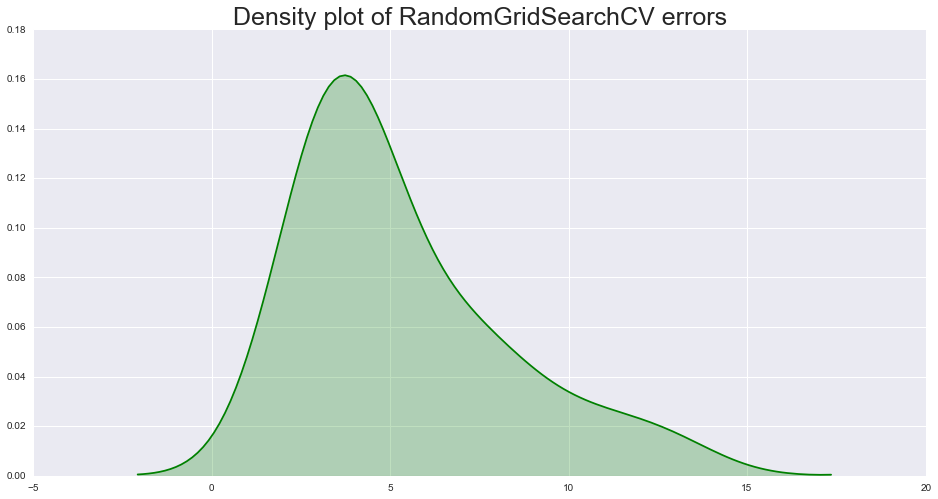

In [25]:
matplotlib.rcParams['figure.figsize'] = (16, 8)
sns.set_style("darkgrid")
ax = sns.kdeplot(np.array(errors), shade=True, color='g')
plt.title('Density plot of RandomGridSearchCV errors', fontsize=25)
sns.plt.show()

##  Next, we plot the predicted vs true values for a specific tuning hyperpameter just for illustration

In [27]:
import random
# We chooce randomly tuned hypermaters from the list(hyperm)
est.set_params(**hyperm[random.randint(0, len(hyperm))])
est.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='huber', max_depth=2, max_features=11,
             max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1700,
             random_state=None, subsample=0.9, verbose=0, warm_start=False)

In [28]:
(np.mean(abs(y_test-est.predict(X_test))/y_test))*100

6.1400875731697084

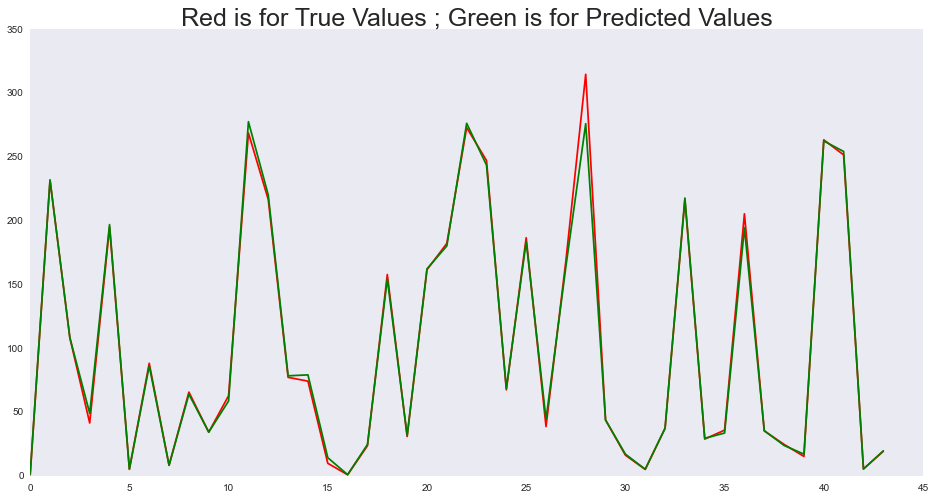

In [29]:
sns.set_style("dark")
plt.plot(y_test.values, 'r')
plt.plot(est.predict(X_test), 'g')
plt.title('Red is for True Values ; Green is for Predicted Values ', fontsize=25)
sns.plt.show()